## RQ2. How frequent are, and what are the main characteristics of long-lived bugs in FLOSS projects?

## Experimental parameters


| Parameter                  |         Value        |
|----------------------------|:--------------------:|
| OSS Project                |        Eclipse       |
| Number of Bug Reports      |        8438          |
| Threshold (in days)        |          365         |

Every bug which its report have indicated that the number of days to resolve is less than or equal to **threshold fixed** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**. 

## Step1. Setup experimental environment.

In [87]:
import matplotlib.pyplot as plt 
import nltk 
import numpy as np
import pandas as pd
import seaborn as sns 
import string

from nltk.stem   import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Setup matplotlib and seaborn
plt.rc('figure', figsize=(20, 20))
plt.style.use('default')
%matplotlib inline 

sns.set_context("paper")

# Setup NLTK
stemmer = PorterStemmer()
nltk.download('punkt')
nltk.download('stopwords')

# Path of the file to read.
bug_reports_path = 'datasets/20190824_eclipse_bug_report_data.csv'
bug_reports_history_path = 'datasets/20190824_eclipse_bug_report_history_data.csv'

# Fixed time threshold.
bug_fix_time_threshold = 365
print("Setup complete")

Setup complete


[nltk_data] Downloading package punkt to /home/luiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/luiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 2. Load data.

In [29]:

!echo "Header of bug reports file"
!head -n 2 $bug_reports_path

!echo "\nNumber of lines in the file:"
!wc -l $bug_reports_path


Header of bug reports file
bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code
EMF-354412,2011-08-10,cdo.core,EMF,containsAll returns wrong result in case of detached objects,"Cloned from: 354395: containsAll returns wrong result in case of detached objects

Number of lines in the file:
339097 datasets/20190824_eclipse_bug_report_data.csv


In [30]:
bug_reports_data = pd.read_csv(bug_reports_path)
rows_and_cols = bug_reports_data.shape
print('There are {} rows and {} columns.\n'.format(
        rows_and_cols[0], rows_and_cols[1]
    )
)

print(bug_reports_data.info())

There are 21391 rows and 19 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21391 entries, 0 to 21390
Data columns (total 19 columns):
bug_id                  21391 non-null object
creation_date           21391 non-null object
component_name          21391 non-null object
product_name            21391 non-null object
short_description       21390 non-null object
long_description        21084 non-null object
assignee_name           21391 non-null object
reporter_name           21391 non-null object
resolution_category     21391 non-null object
resolution_code         21391 non-null int64
status_category         21391 non-null object
status_code             21391 non-null int64
update_date             21391 non-null object
quantity_of_votes       21391 non-null int64
quantity_of_comments    21391 non-null int64
resolution_date         21391 non-null object
bug_fix_time            21391 non-null int64
severity_category       21391 non-null object
severity_code           21391 

In [31]:
!echo "Header of bug reports history file"
!head -n 2 $bug_reports_history_path

!echo "\nNumber of lines in the history file:"
!wc -l $bug_reports_history_path


Header of bug reports history file
Key,Who,When,What,Removed,Added
EMF-354412,stepper,2011-08-10,status,new,assigned

Number of lines in the history file:
168721 datasets/20190824_eclipse_bug_report_history_data.csv


In [32]:
bug_reports_history_data = pd.read_csv(bug_reports_history_path, sep=',')
rows_and_cols = bug_reports_history_data.shape
print('There are {} rows and {} columns.\n'.format(
        rows_and_cols[0], rows_and_cols[1]
    )
)

print(bug_reports_history_data.info())

There are 168720 rows and 6 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168720 entries, 0 to 168719
Data columns (total 6 columns):
Key        168720 non-null object
Who        168720 non-null object
When       168720 non-null object
What       168720 non-null object
Removed    128344 non-null object
Added      167259 non-null object
dtypes: object(6)
memory usage: 7.7+ MB
None


## Step 3. Review the data

In [33]:
bug_reports_history_data.head()

Key      Who        When        What        Removed     Added
0  EMF-354412  stepper  2011-08-10      status            new  assigned
1  EMF-354412  stepper  2011-08-10    assignee  emf.cdo-inbox   stepper
2  EMF-354412  stepper  2011-08-10      status       assigned  resolved
3  EMF-354412  stepper  2011-08-10  resolution            ---     fixed
4  EMF-354412  stepper  2012-09-21      status       resolved    closed

## Step 4. Pre-processing the data

In [95]:
bug_reports_data['resolution_code'] = bug_reports_data['resolution_code'].astype('category')
bug_reports_data['status_category'] = bug_reports_data['status_category'].astype('category')
bug_reports_data['severity_code']   = bug_reports_data['severity_code'].astype('category')
bug_reports_data['short_description'] = bug_reports_data['short_description'].fillna("")
bug_reports_data['long_description'] = bug_reports_data['long_description'].fillna("")
bug_reports_data['short_description_length'] = bug_reports_data['short_description'].str.split().apply(lambda l: len(l))
bug_reports_data['long_description_length']  = bug_reports_data['long_description'].str.split().apply(lambda l: len(l))
bug_reports_data['short_description_length'] = bug_reports_data['short_description_length'].fillna(0)
bug_reports_data['long_description_length'] = bug_reports_data['long_description_length']
bug_reports_data['long_lived?']  = bug_reports_data['bug_fix_time'].apply(lambda t: 'long-lived' if t > 365 else 'short-lived')
bug_reports_data['long_lived?']  = bug_reports_data['long_lived?'].astype('category')
bug_reports_data.head()

bug_id creation_date component_name product_name  \
0          EMF-354412    2011-08-10       cdo.core          EMF   
1         JSDT-253166    2008-11-03        General         JSDT   
2  ECLIPSELINK-338573    2011-03-01            SDO  ECLIPSELINK   
3         BIRT-150200    2006-07-10          Chart         BIRT   
4      PAPYRUS-384964    2012-07-12           Core      PAPYRUS   

                                   short_description  \
0  containsAll returns wrong result in case of de...   
1  Javascript validation has several errors with ...   
2  Memory Improvement:  Reduce the instances of S...   
3  Stacked Area Chart: fill.set() ignored in befo...   
4  [StateMachine Diagram] Papyrus does not forbid...   

                                    long_description       assignee_name  \
0  Cloned from: 354395: containsAll returns wrong...             stepper   
1  Some of our javascript-files yield parse-error...              cmjaun   
2  Currently the SDO/OXM metadata is referring to...      blaise.doughan   
3  In the attached report the fill.set() is being...                 nli   
4  In some situation (seem to be when an element ...  ansgar.radermacher   

    reporter_name resolution_category resolution_code  ... update_date  \
0         stepper               fixed               1  ...  2012-09-21   
1             acm               fixed               1  ...  2010-03-03   
2  blaise.doughan               fixed               1  ...  2011-03-02   
3         eclipse               fixed               1  ...  2010-03-24   
4     yann.tanguy               fixed               1  ...  2013-04-02   

   quantity_of_votes quantity_of_comments  resolution_date  bug_fix_time  \
0                  0                    5       2011-08-10             0   
1                  0                    6       2009-04-29           177   
2                  0                    5       2011-03-02             1   
3                  0                    7       2006-08-29            50   
4                  0                    3       2013-04-02           264   

  severity_category  severity_code short_description_length  \
0            normal              2                        9   
1            normal              2                        8   
2            normal              2                        7   
3             major              4                        7   
4          critical              5                       14   

  long_description_length  long_lived?  
0                     134  short-lived  
1                     179  short-lived  
2                      23  short-lived  
3                      29  short-lived  
4                      73  short-lived  

[5 rows x 22 columns]

## Step 5. How frequent are long-lived bugs?

[None]

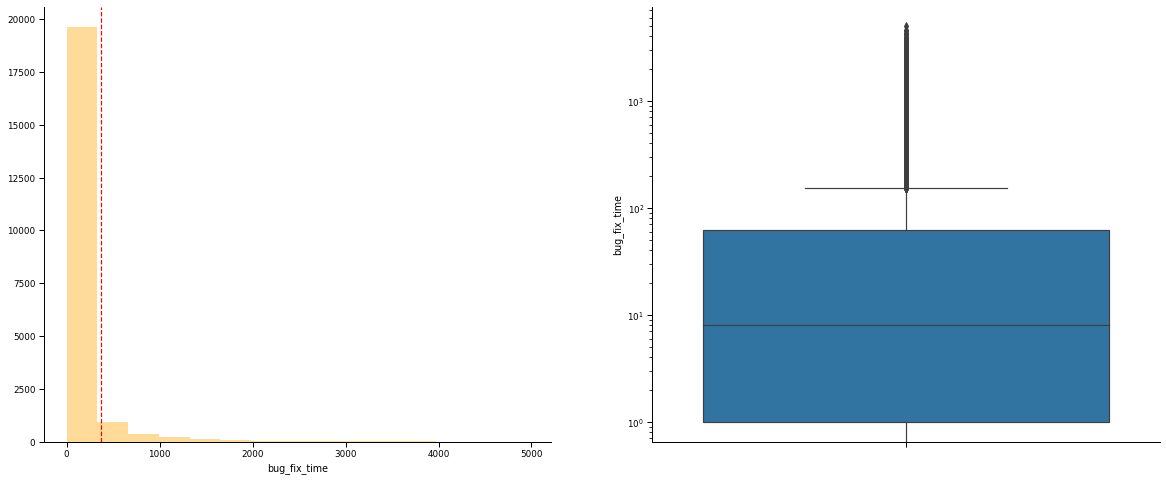

In [113]:
fig, ax = plt.subplots(figsize=(20,8), ncols=2)
sns.despine()
g = sns.distplot(bug_reports_data['bug_fix_time'], kde=False, bins=15, hist=True, color="orange", ax=ax[0])
g.axvline(bug_fix_time_threshold, color='r', linestyle='--', label = "Threshold : {}".format(bug_fix_time_threshold))
g = sns.boxplot(y="bug_fix_time", data=bug_reports_data, showfliers=True, ax=ax[1])
g.set(yscale="log")

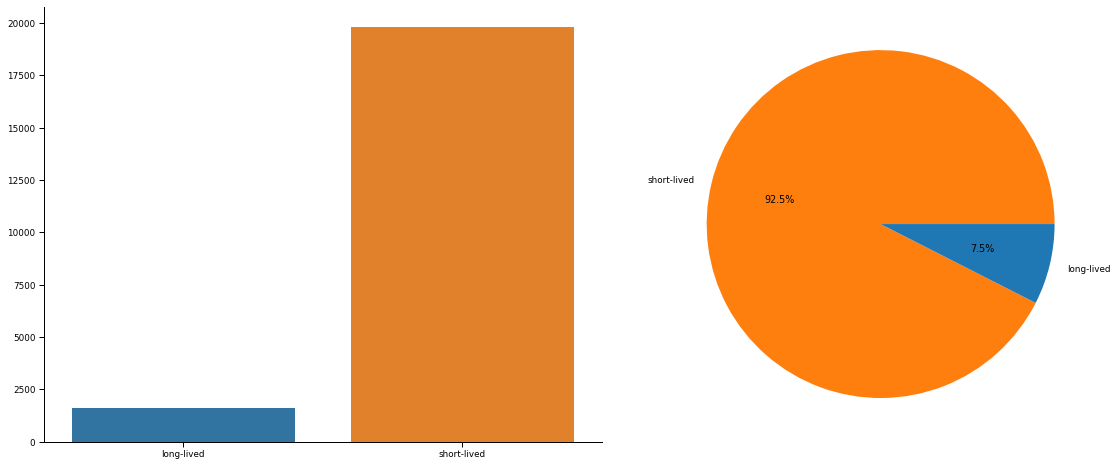

In [97]:
bug_reports_count = bug_reports_data["long_lived?"].value_counts()

f, axes = plt.subplots(figsize=(20,8), ncols=2)
sns.despine()

sns.barplot(x=bug_reports_count.index, y=bug_reports_count.values, palette=[ "tab:blue", "tab:orange"], ax=axes[0])
axes[1].pie(bug_reports_count.values, labels=bug_reports_count.index, autopct='%1.1f%%', colors=["tab:orange", "tab:blue"])

plt.subplots_adjust(wspace=0, hspace=1)

## Step 6. How is the distribution of severity level?

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Distribution of severity level')]

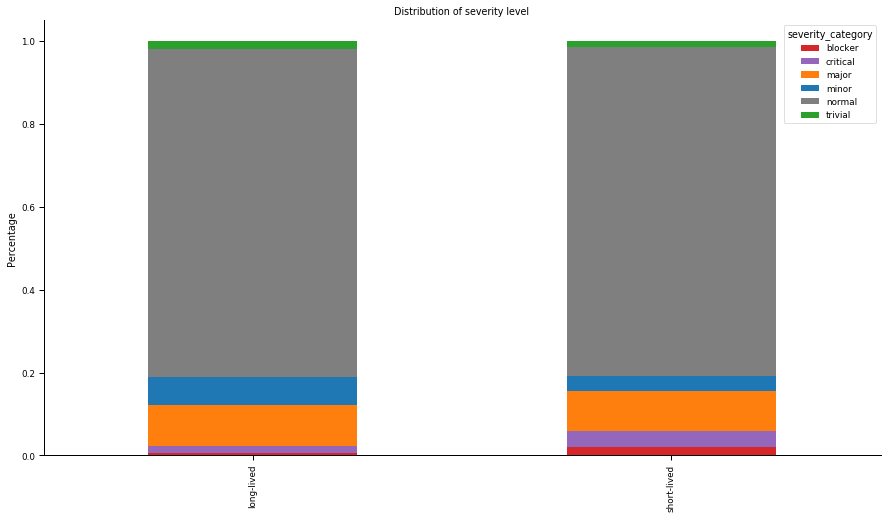

In [98]:
fig, axes = plt.subplots(figsize=(15,8))
sns.despine()
severity_palette=color=["tab:red", "tab:purple", "tab:orange", "tab:blue", "tab:gray", "tab:green"]
bug_reports_data_grouped = bug_reports_data.groupby("long_lived?")['severity_category'].value_counts(normalize=True).unstack()
bug_reports_data_grouped.plot(kind='bar', stacked='True', color=severity_palette, ax=axes)

axes.set(title="Distribution of severity level", xlabel="", ylabel="Percentage")


[None]

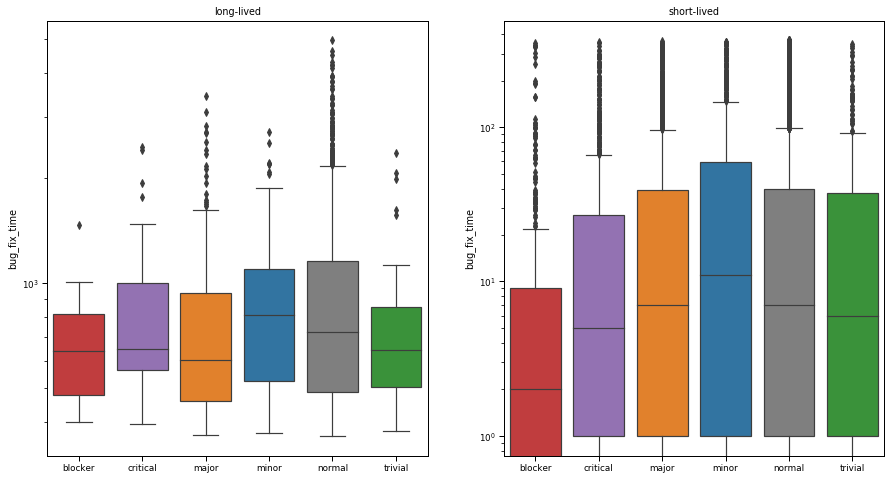

In [112]:
fig, ax = plt.subplots(figsize=(15,8), ncols=2)

g1 = sns.boxplot(data=bug_reports_data[bug_reports_data['long_lived?']=='long-lived']
                 , x="severity_category", y="bug_fix_time"
                , order=['blocker', 'critical', 'major', 'minor', 'normal', 'trivial']
                , palette=severity_palette
                , showfliers=True
                , ax=ax[0])
g1.set(title="long-lived", xlabel="")
g1.set(yscale="log")

g2 = sns.boxplot(data=bug_reports_data[bug_reports_data['long_lived?']=='short-lived']
                 , x="severity_category", y="bug_fix_time"
                , order=['blocker', 'critical', 'major', 'minor', 'normal', 'trivial']
                , palette=severity_palette
                , showfliers=True
                , ax=ax[1])
g2.set(title="short-lived", xlabel="")
g2.set(yscale="log")


## Step 7. How is the distribution of number of chracters in short and long description?

[None]

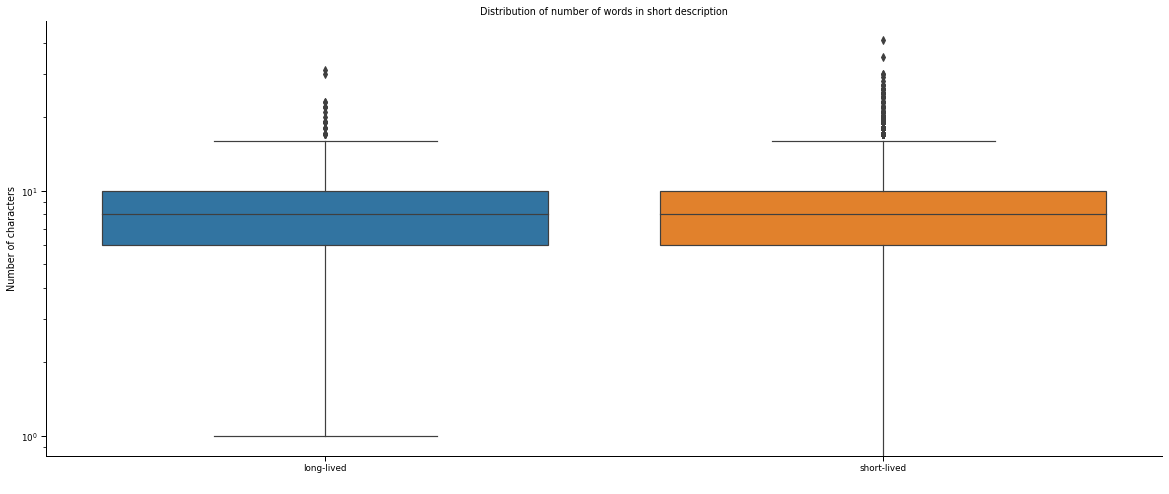

In [114]:
fig, ax = plt.subplots(figsize=(20,8), ncols=1)
sns.despine()

#g = sns.violinplot(x="long_lived?", y="short_description_length", data=bug_reports_data)
g = sns.boxplot(x="long_lived?", y="short_description_length", data=bug_reports_data, showfliers=True)
g.set(title="Distribution of number of words in short description", ylabel="Number of characters", xlabel=" ")
g.set(yscale="log")

[None]

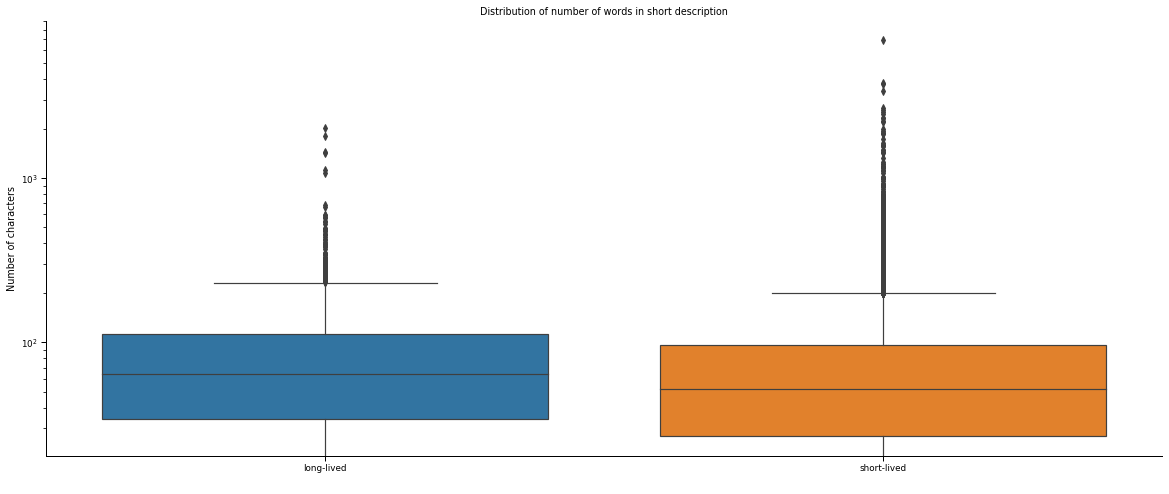

In [107]:
fig, ax = plt.subplots(figsize=(20,8), ncols=1)
sns.despine()

#g = sns.violinplot(x="long_lived?", y="long_description_length", data=bug_reports_data)
g = sns.boxplot(x="long_lived?", y="long_description_length", data=bug_reports_data, showfliers=True)
g.set(title="Distribution of number of words in short description", ylabel="Number of characters", xlabel=" ")
g.set(yscale="log")

### Step 8. Bug Reporter

In [42]:
number_of_reports   = bug_reports_data['bug_id'].count()
number_of_reporters = bug_reports_data['reporter_name'].nunique()
print("%s reporters reported %s bugs." % (number_of_reporters, number_of_reports))

4614 reporters reported 21391 bugs.


In [43]:
top_10_reporters = bug_reports_data.groupby('reporter_name').reporter_name.agg(['count'])
top_10_reporters = top_10_reporters.sort_values('count', ascending=False)[0:10]
top_10_reporters

count
reporter_name        
david_williams    278
eclipse           226
markus.kell.r     193
wayne.beaton      193
john.arthorne     174
Lars.Vogel        150
ed                146
pascal            144
daniel_megert     141
lchen             137

[None]

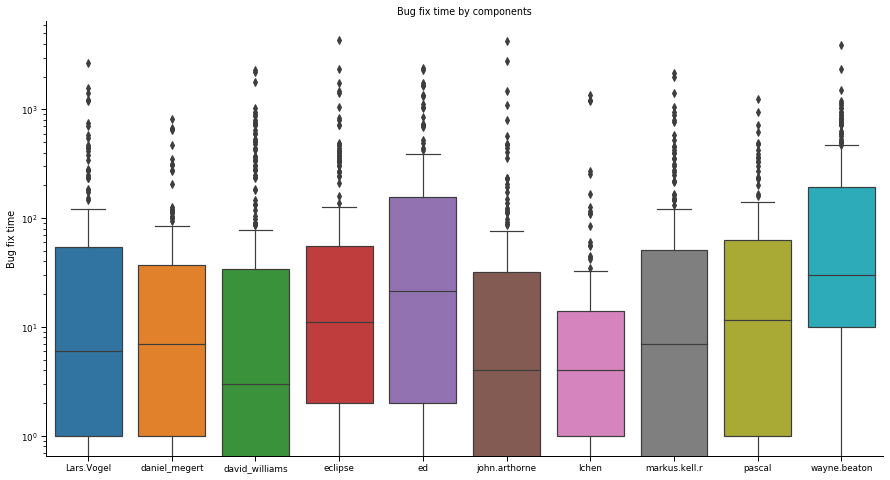

In [109]:
fig, ax = plt.subplots(figsize=(15,8))
sns.despine()
bug_reports_data_for_top_10_reporters=bug_reports_data[bug_reports_data['reporter_name'].isin(top_10_reporters.index)]
bug_reports_data_for_top_10_reporters=bug_reports_data_for_top_10_reporters.sort_values(by=['reporter_name'])
g = sns.boxplot(data=bug_reports_data_for_top_10_reporters
            , x="reporter_name"
            , y="bug_fix_time"
            , showfliers=True)
g.set(title="Bug fix time by components", xlabel="", ylabel="Bug fix time")
g.set(yscale="log")

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Bug reports by reporter')]

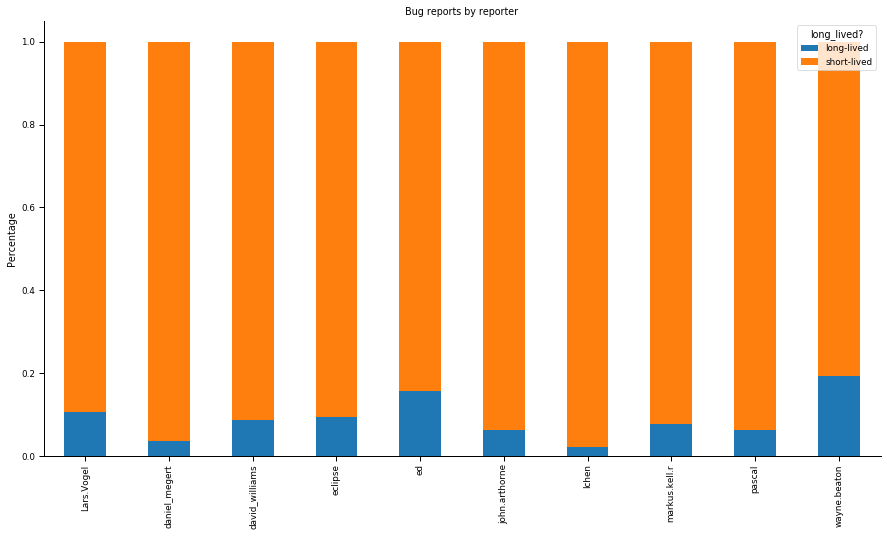

In [45]:
fig, axes = plt.subplots(figsize=(15,8))
sns.despine()
palette=color=["tab:blue", "tab:orange"]
bug_reports_data_grouped = bug_reports_data_for_top_10_reporters.groupby("reporter_name")['long_lived?'].value_counts(normalize=True).unstack()
bug_reports_data_grouped.plot(kind='bar', stacked='True', color=palette, ax=axes)

axes.set(title="Bug reports by reporter", xlabel="", ylabel="Percentage")


## Step 9. Assignee

In [46]:
top_10_assignee = bug_reports_data.groupby('assignee_name').assignee_name.agg(['count'])
top_10_assignee = top_10_assignee.sort_values('count', ascending=False)[0:9]
top_10_assignee

count
assignee_name           
webmaster            468
rap-inbox            243
tmf.xtext-inbox      230
Silenio_Quarti       196
emo                  174
eclipse              166
mdt-papyrus-inbox    164
david_williams       157
pde-ui-inbox         154

[None]

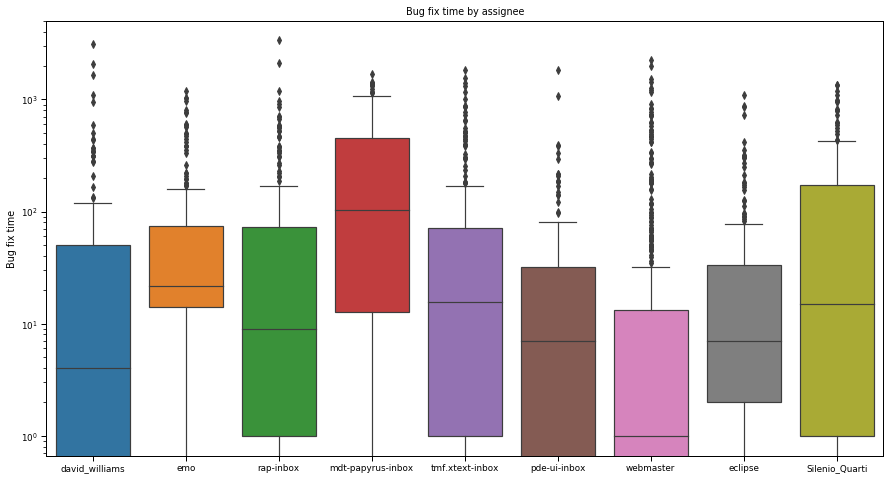

In [110]:
fig, ax = plt.subplots(figsize=(15,8))
bug_reports_data_for_top_10_assignee=bug_reports_data[bug_reports_data['assignee_name'].isin(top_10_assignee.index)] 
g = sns.boxplot(data=bug_reports_data_for_top_10_assignee
            , x="assignee_name"
            , y="bug_fix_time"
            , showfliers=True)
g.set(title="Bug fix time by assignee", xlabel="", ylabel="Bug fix time")
g.set(yscale="log")

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Bug reports by assignee')]

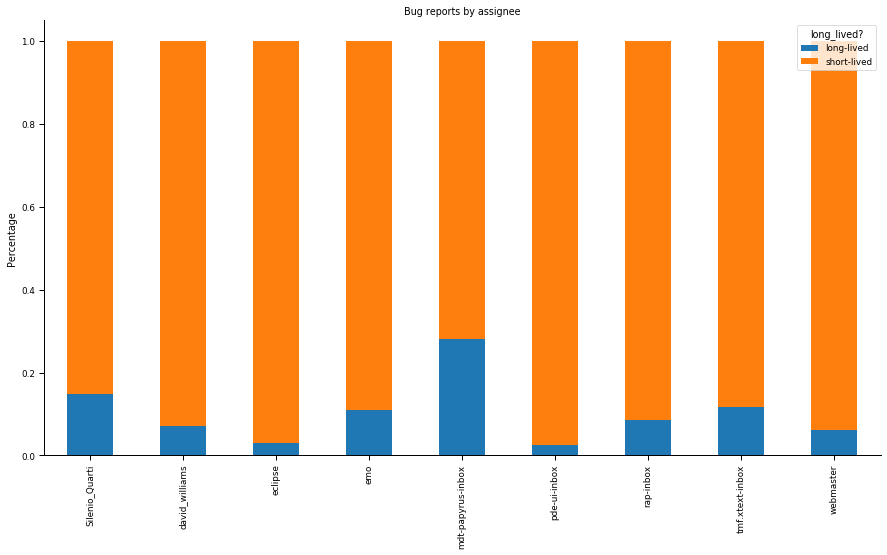

In [48]:
fig, axes = plt.subplots(figsize=(15,8))
sns.despine()
palette=color=["tab:blue", "tab:orange"]
bug_reports_data_grouped = bug_reports_data_for_top_10_assignee.groupby("assignee_name")['long_lived?'].value_counts(normalize=True).unstack()
bug_reports_data_grouped.plot(kind='bar', stacked='True', color=palette, ax=axes)

axes.set(title="Bug reports by assignee", xlabel="", ylabel="Percentage")

## Step 10. Component

In [49]:
top_10_component = bug_reports_data.groupby('component_name').component_name.agg(['count'])
top_10_component = top_10_component.sort_values('count', ascending=False)[0:10]
top_10_component

count
component_name       
UI               2346
Core             1697
SWT               783
TPTP              613
General           430
Releng            405
Client            345
cdt-core          287
Xtext             268
Hyades            265

[None]

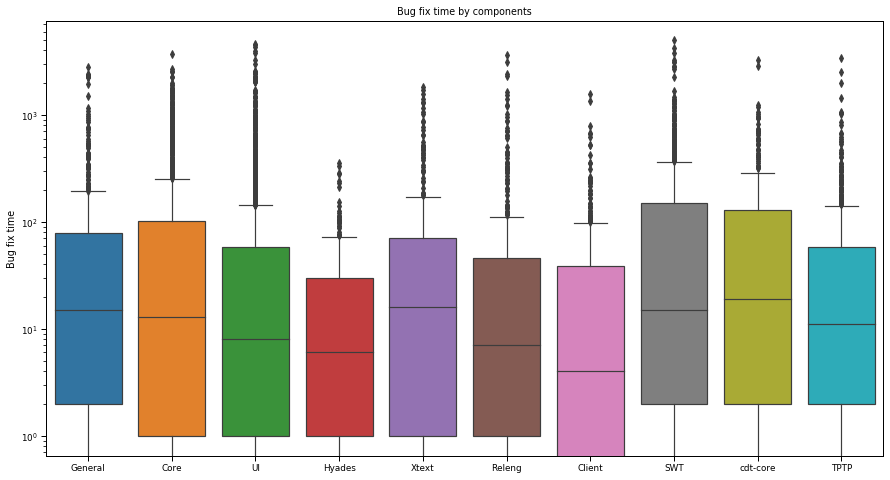

In [111]:
fig, ax = plt.subplots(figsize=(15,8))
bug_reports_data_for_top_10_component=bug_reports_data[bug_reports_data['component_name'].isin(top_10_component.index)] 
g = sns.boxplot(data=bug_reports_data_for_top_10_component
            , x="component_name"
            , y="bug_fix_time"
            , showfliers=True)
g.set(title="Bug fix time by components", xlabel="", ylabel="Bug fix time")
g.set(yscale="log")

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Bug reports by components')]

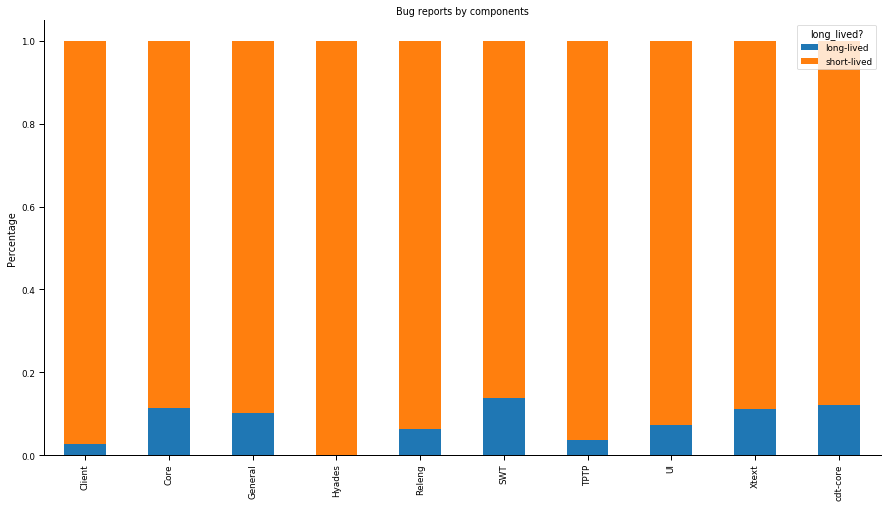

In [51]:
fig, axes = plt.subplots(figsize=(15,8))
sns.despine()
palette=color=["tab:blue", "tab:orange"]
bug_reports_data_grouped = bug_reports_data_for_top_10_component.groupby("component_name")['long_lived?'].value_counts(normalize=True).unstack()
bug_reports_data_grouped.plot(kind='bar', stacked='True', color=palette, ax=axes)

axes.set(title="Bug reports by components", xlabel="", ylabel="Percentage")

## Step 11. Analysis of Short and Long Descrption

### Short Description Word cloud

In [59]:
def join_all_descriptions(descriptions):
    text = " ".join(description for description in descriptions)
    return text.lower()

def plot_one_word_cloud(text, title, axe, stopwords=""):
    if (stopwords==""):
        sl_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    else:
        sl_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords).generate(text)
    axe.imshow(sl_wordcloud, interpolation='bilinear')
    axe.set_title(title)
    axe.axis("off")

def stem_sentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(stemmer.stem(word))
        stem_sentence.append(" ")
        
    return "".join(stem_sentence)

def plot_all_word_clouds(sl_descriptions, ll_descriptions, title, apply_text_mining=False):
    fig, ax = plt.subplots(figsize=(30,30), ncols=2)

    sl_text = join_all_descriptions(sl_descriptions)
    ll_text = join_all_descriptions(ll_descriptions)

    if (apply_text_mining):
        # Load stop words
        stop_words = stopwords.words('english')
        stop_words.extend(['eclipse', 'org', 'xml', 'java', 'project', 'view', 'editor', 'file', 'test', 'update', 'will'])
       
        sl_text = sl_text.translate(str.maketrans('', '', string.punctuation))
        ll_text = ll_text.translate(str.maketrans('', '', string.punctuation))
        
        sl_text = ' '.join([word for word in sl_text.split() if word not in stop_words])
        ll_text = ' '.join([word for word in ll_text.split() if word not in stop_words])
        
        sl_text = stem_sentence(sl_text)
        ll_text = stem_sentence(ll_text)
        
    plot_one_word_cloud(sl_text, 'Word Cloud for {} [Short-Lived Bugs]'.format(title), ax[0])
    plot_one_word_cloud(ll_text, 'Word Cloud for {} [Long-Lived Bugs]'.format(title), ax[1])


    

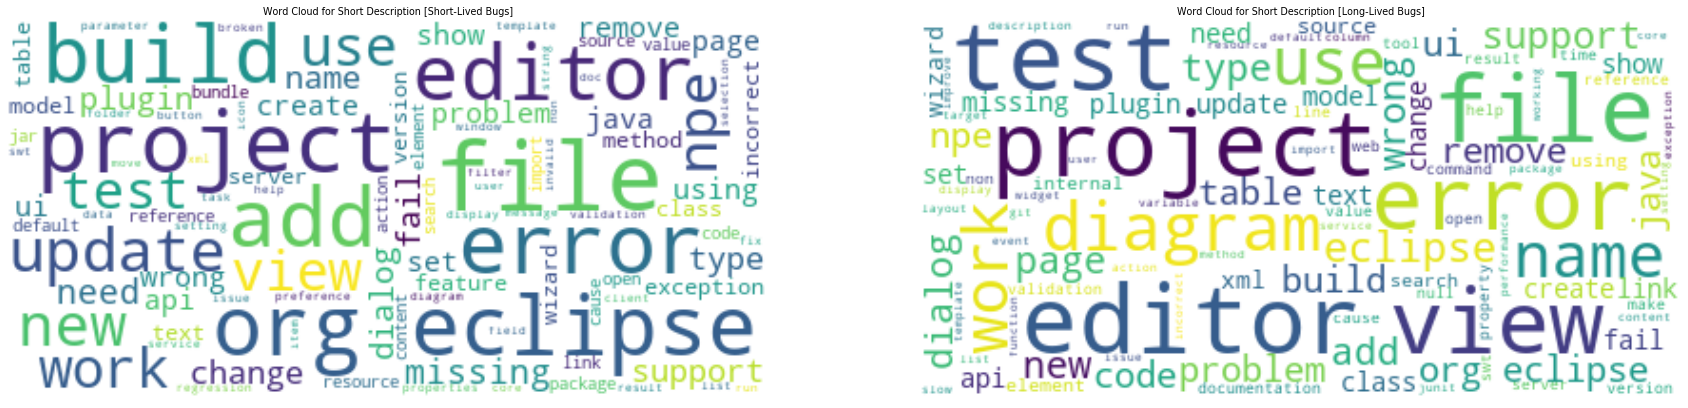

In [60]:
plot_all_word_clouds(bug_reports_data[bug_reports_data['long_lived?']=='short-lived'].short_description,
                     bug_reports_data[bug_reports_data['long_lived?']=='long-lived'].short_description,
                    'Short Description')

### Short Description Word cloud with Text Mining

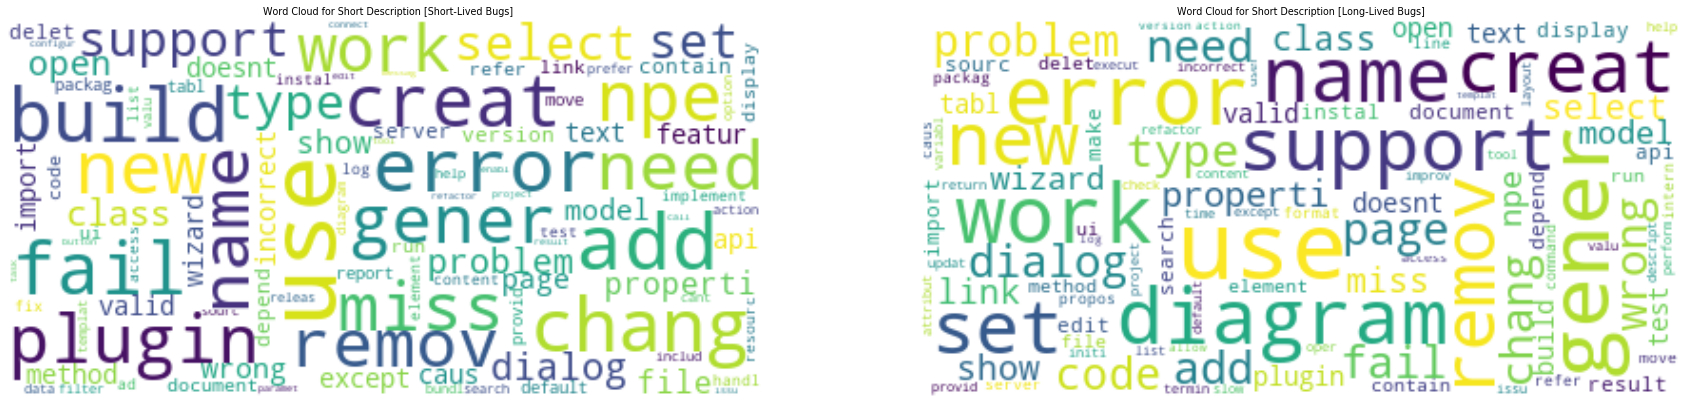

In [61]:
plot_all_word_clouds(bug_reports_data[bug_reports_data['long_lived?']=='short-lived'].short_description,
                     bug_reports_data[bug_reports_data['long_lived?']=='long-lived'].short_description,
                    'Short Description', True)

### Long Description Word cloud

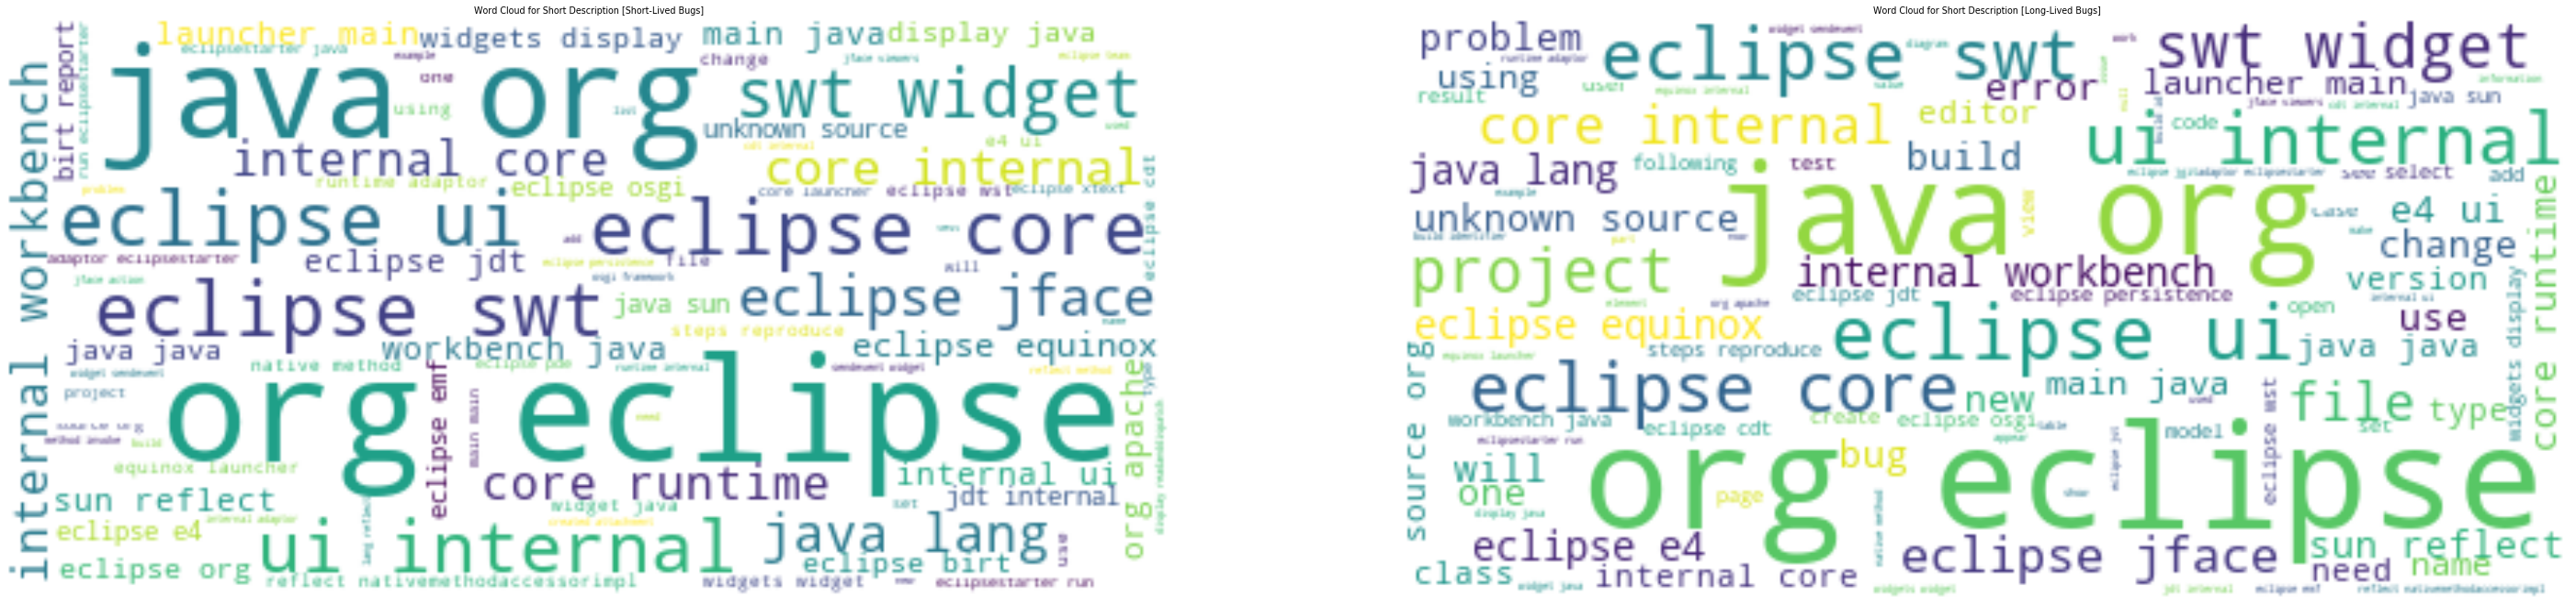

In [55]:
plot_all_word_clouds(bug_reports_data[bug_reports_data['long_lived?']=='short-lived'].long_description,
                     bug_reports_data[bug_reports_data['long_lived?']=='long-lived'].long_description,
                    'Short Description', False)

### Long Description Word cloud with Text Mining

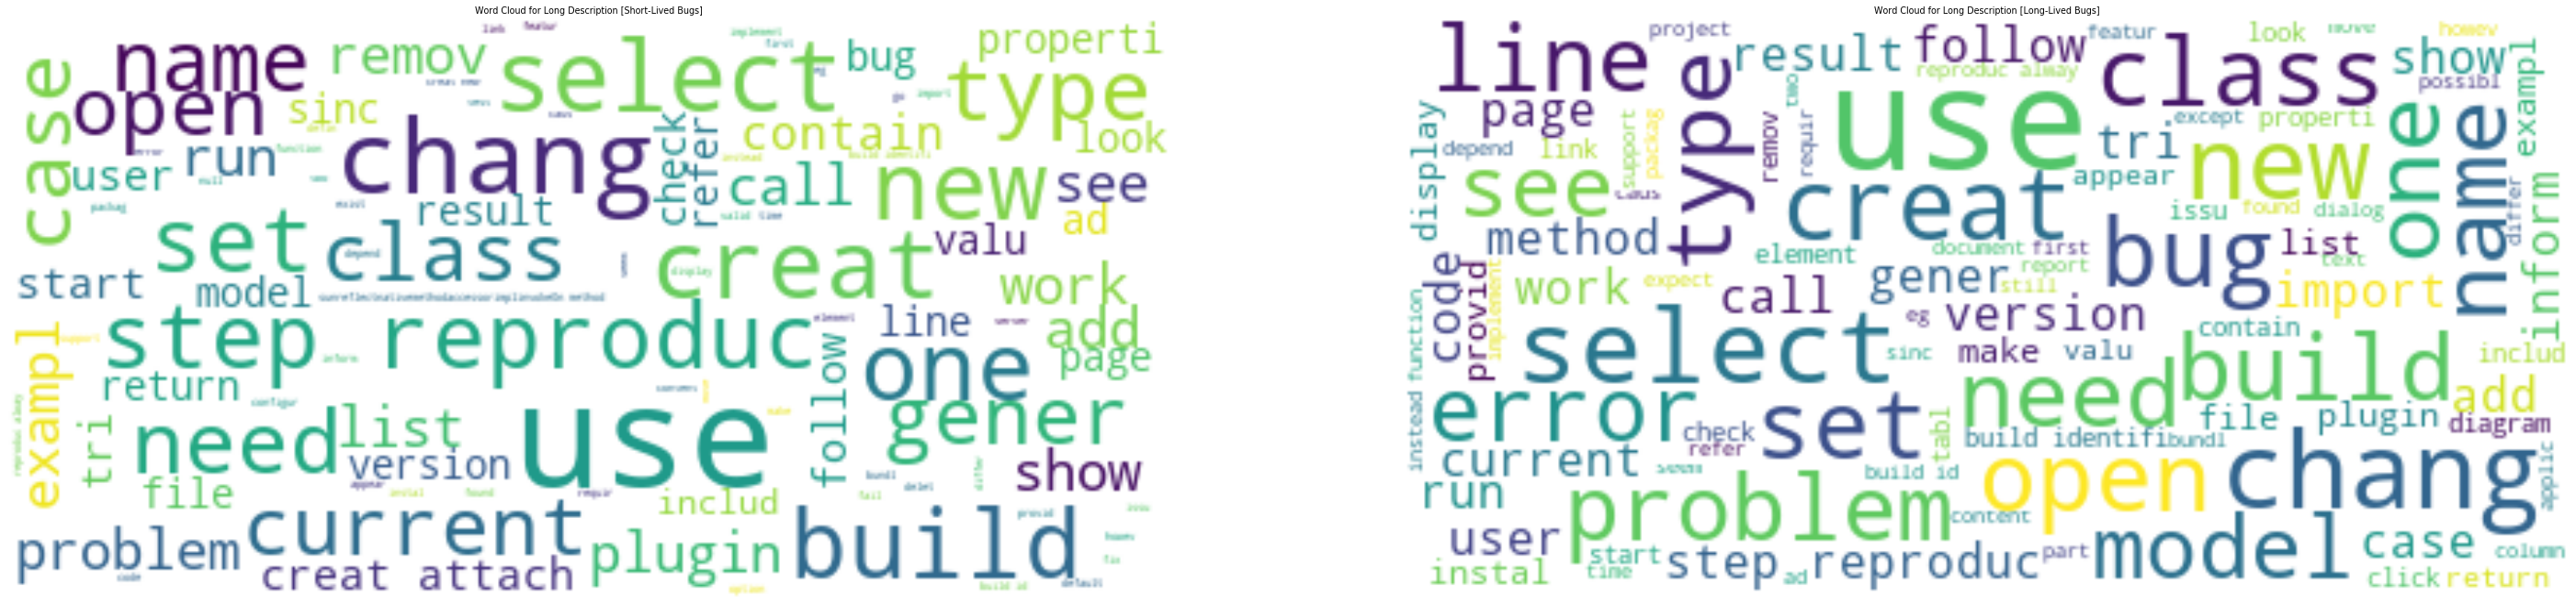

In [56]:
plot_all_word_clouds(bug_reports_data[bug_reports_data['long_lived?']=='short-lived'].long_description,
                     bug_reports_data[bug_reports_data['long_lived?']=='long-lived'].long_description,
                    'Long Description', True)

/home/luiz/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


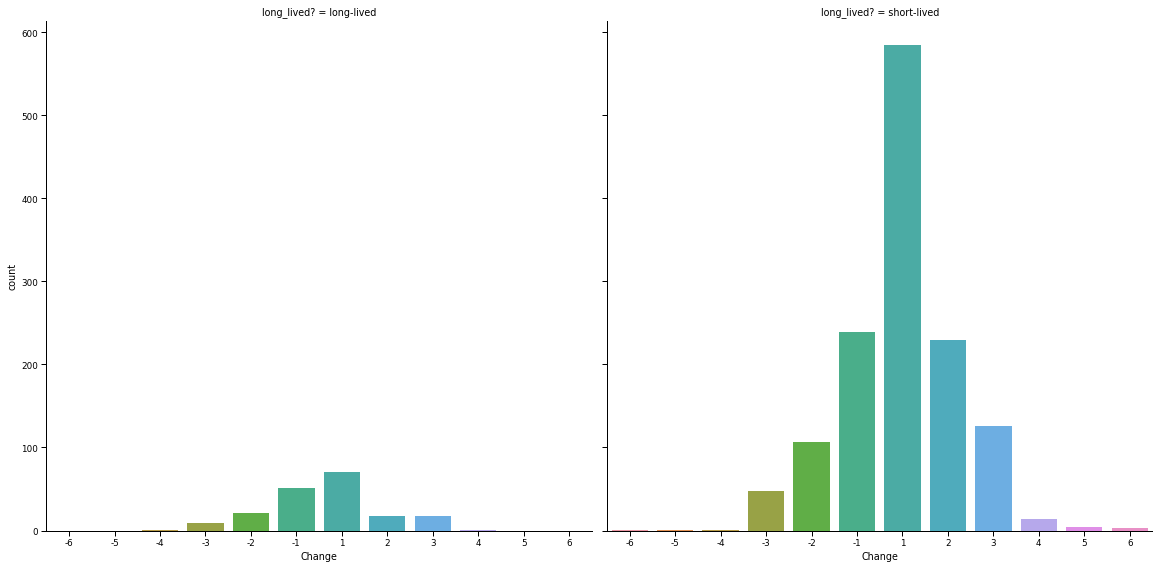

In [92]:
severity_levels = {'trivial':1, 'minor':2, 'normal':3, 'major':4, 'critical':5, 'blocker':6, 'enhancement':0}
bug_reports_history_merged = pd.merge(
    bug_reports_history_data,
    bug_reports_data[['bug_id', 'creation_date', 'update_date', 'resolution_date', 'bug_fix_time', 'long_lived?']],
    left_on='Key',
    right_on='bug_id',
    how='left'
)
    
severity_changes_data = bug_reports_history_merged[(bug_reports_history_merged['What'] == 'severity')]
severity_changes_data.loc[:, 'Removed'] = [severity_levels[level] for level in severity_changes_data.loc[:, 'Removed']]
severity_changes_data.loc[:, 'Added'] = [severity_levels[level] for level in severity_changes_data.loc[:, 'Added']]
severity_changes_data['Change'] = severity_changes_data['Added'] - severity_changes_data['Removed']

sns.catplot(x="Change", col="long_lived?",data=severity_changes_data, kind="count",height=8, aspect=1);



In [94]:
assignee_changes_data = bug_reports_history_merged[(bug_reports_history_merged['What'] == 'assignee')]
assignee_changes_data

Key                     Who        When  \
1                      EMF-354412                 stepper  2011-08-10   
5                     JSDT-253166                berkland  2008-11-10   
8                     JSDT-253166                  nitind  2009-04-29   
26             ECLIPSELINK-338573          blaise.doughan  2011-03-01   
33                    BIRT-150200             dmichonneau  2006-07-11   
46                 PAPYRUS-384964            cletavernier  2013-03-01   
49      WTP_SOURCE_EDITING-136400                 csalter  2006-04-12   
52      WTP_SOURCE_EDITING-136400          david_williams  2006-06-14   
59                 EQUINOX-259283                  pascal  2008-12-22   
75               Z_ARCHIVED-58853                 popescu  2004-04-16   
137                    TMF-348894           jan.koehnlein  2011-07-05   
158                     CDT-95461            john.camelon  2005-05-16   
164                   BIRT-339960             wenfeng.fwd  2011-03-14   
168                   BIRT-339960             bluesoldier  2011-05-24   
175                   BIRT-260810                   zqian  2009-01-13   
182                PLATFORM-28169          dean.t.roberts  2003-01-13   
188             WTP_RELENG-170969                 jlanuti  2007-01-24   
195            LINUX_TOOLS-488976                 xcoulon  2016-03-15   
204        WTP_WEBSERVICES-246917           valentinbaciu  2008-09-12   
215                   STEM-205746               webdaford  2007-10-08   
232                     JDT-90279            dirk_baeumer  2005-04-05   
238             Z_ARCHIVED-173426                 bulrich  2007-02-13   
244                   BIRT-144895             wenfeng.fwd  2006-06-01   
246                   BIRT-144895                    slee  2006-06-01   
271                PLATFORM-22450            knut_radloff  2002-08-27   
272                PLATFORM-22450         eduardo_pereira  2002-09-03   
275                PLATFORM-22450         eduardo_pereira  2002-09-25   
282                   ERCP-213282                   liukl  2008-07-14   
285                      JDT-9008          philippe_mulet  2002-02-04   
303                PAPYRUS-319579             yann.tanguy  2010-07-12   
322               PLATFORM-241144                gheorghe  2008-07-16   
334                PLATFORM-47763             grant_gayed  2003-12-01   
358             Z_ARCHIVED-465898                    sewe  2015-05-27   
389               PLATFORM-363215                kim.moir  2011-11-08   
391               PLATFORM-363215           john.arthorne  2011-11-09   
396               PLATFORM-363215           john.arthorne  2011-11-15   
403                  JETTY-471818                   gregw  2015-07-08   
409                  JETTY-471818           simone.bordet  2015-07-08   
413                    PDT-139028                 shachar  2006-06-06   
418      TARGET_MANAGEMENT-262092                dmcknigh  2009-01-22   
423                    JDT-415821       srikanth_sankaran  2013-08-25   
431                 NEBULA-525390                 caosmpz  2018-04-27   
445                EQUINOX-413879                tjwatson  2013-07-29   
450                 SIRIUS-431132    pierre-charles.david  2014-03-25   
484                PLATFORM-31493             dj.houghton  2003-02-10   
486                PLATFORM-31493          sonia_dimitrov  2003-02-11   
492                PLATFORM-31493           daniel_megert  2007-10-12   
499              Z_ARCHIVED-57959                 popescu  2004-04-08   
501              Z_ARCHIVED-57959                   shiah  2004-04-08   
526                   BIRT-232875                   zqian  2008-05-19   
546             Z_ARCHIVED-217996                 aog-ecl  2008-02-06   
585            ECLIPSELINK-282751          lukas.jungmann  2014-08-27   
587                  JETTY-350642          joakim.erdfelt  2011-06-28   
590                  JETTY-350642                   gregw  2011-06-28   
591            